
Imports & magic


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



Load Fashion-MNIST the TF-way (28×28, 0-255 → 0-1)

In [13]:
def preprocess(img, lbl):
    img = tf.cast(img, tf.float32) / 255.0
    return img, lbl

# 60 k train + 10 k test
train_ds, test_ds = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True
)

class_names = ['T-shirt','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

Data augmentation

In [14]:
AUG = tf.keras.Sequential([
    layers.RandomCrop(28, 28),          # tiny jitter still fits 28×28 canvas
    layers.RandomFlip("horizontal")
])

Build train / validation / test pipelines

In [15]:
BATCH = 128
AUTO  = tf.data.AUTOTUNE

train_ds = (train_ds
            .shuffle(60000)
            .map(preprocess, num_parallel_calls=AUTO)
            .batch(BATCH)
            .map(lambda x,y: (AUG(x, training=True), y), num_parallel_calls=AUTO)
            .prefetch(AUTO))

# 5 k samples for validation
val_ds = (train_ds
          .unbatch()
          .take(5000)
          .batch(BATCH)
          .prefetch(AUTO))

train_ds = (train_ds
            .unbatch()
            .skip(5000)
            .batch(BATCH)
            .prefetch(AUTO))

test_ds  = (test_ds
            .map(preprocess, num_parallel_calls=AUTO)
            .batch(BATCH)
            .prefetch(AUTO))

CNN + BatchNorm

In [16]:
def make_model():
    inputs = layers.Input(shape=(28,28,1))
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)          # stabilises
    x = layers.MaxPool2D()(x)                   # 14×14

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)                   # 7×7

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)      # replaces Flatten, fewer params

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(10)(x)               # logits

    return models.Model(inputs, outputs)

model = make_model()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,162 (504.54 KB)

 Trainable params: 128,714 (502.79 KB)

 Non-trainable params: 448 (1.75 KB)

LR scheduler + optimiser

In [17]:
lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-5
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Train

In [18]:
EPOCHS = 100
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[lr_schedule],
    verbose=2
)

Epoch 1/100
430/430 - 16s - 38ms/step - accuracy: 0.8188 - loss: 0.5074 - val_accuracy: 0.1692 - val_loss: 6.9749 - learning_rate: 1.0000e-03
Epoch 2/100
430/430 - 5s - 12ms/step - accuracy: 0.8934 - loss: 0.2975 - val_accuracy: 0.8868 - val_loss: 0.3008 - learning_rate: 1.0000e-03
Epoch 3/100
430/430 - 3s - 8ms/step - accuracy: 0.9066 - loss: 0.2564 - val_accuracy: 0.8952 - val_loss: 0.2744 - learning_rate: 1.0000e-03
Epoch 4/100
430/430 - 3s - 8ms/step - accuracy: 0.9150 - loss: 0.2315 - val_accuracy: 0.9124 - val_loss: 0.2413 - learning_rate: 1.0000e-03
Epoch 5/100
430/430 - 14s - 32ms/step - accuracy: 0.9218 - loss: 0.2137 - val_accuracy: 0.9150 - val_loss: 0.2268 - learning_rate: 1.0000e-03
Epoch 6/100
430/430 - 4s - 10ms/step - accuracy: 0.9275 - loss: 0.2020 - val_accuracy: 0.9192 - val_loss: 0.2365 - learning_rate: 1.0000e-03
Epoch 7/100
430/430 - 3s - 8ms/step - accuracy: 0.9317 - loss: 0.1879 - val_accuracy: 0.9266 - val_loss: 0.2073 - learning_rate: 1.0000e-03
Epoch 8/100
43

Plot curves

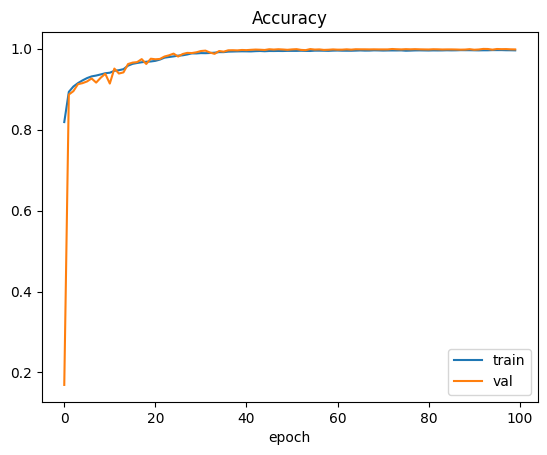

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy"); plt.xlabel("epoch"); plt.legend(); plt.show()

Evaluate on test set

In [20]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy = {test_acc*100:.1f} %")

Test accuracy = 92.7 %


Confusion matrix

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


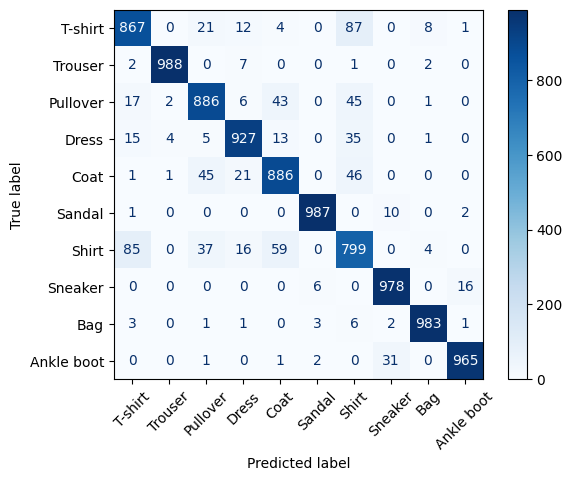

In [21]:
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.show()